### Tratamento dos dados

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
import numpy as np
import datetime

In [7]:
df = pd.read_csv('./data/train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
#para trabalhar com datetime, os índices precisam ser as próprias datas
df = pd.read_csv('./data/train.csv', parse_dates=['datetime'], index_col=0)
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [9]:
df.drop(columns=['season', 'holiday','workingday','weather','temp','atemp', 'humidity','windspeed','casual', 'registered'], axis=1, inplace = True)
df.head()

,count
datetime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


In [10]:
df = df.groupby(pd.Grouper(freq = 'D')).sum() #frequência diária]
df.head()

,count
datetime,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600


Text(0.5, 1.0, 'Aluguel de bicicletas')

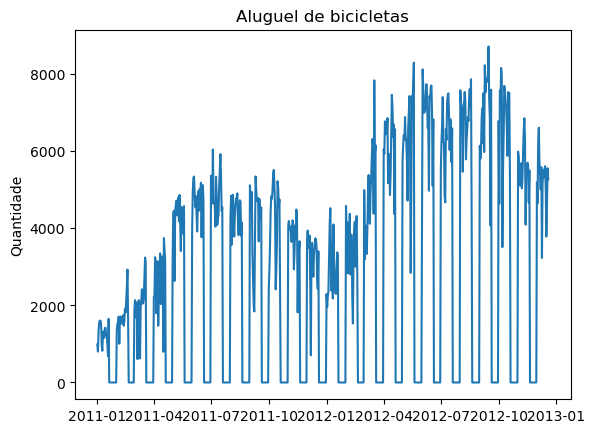

In [11]:
plt.plot(df['count'])
plt.ylabel('Quantidade')
plt.title('Aluguel de bicicletas')

### Configurações do SageMaker

In [12]:
import boto3
import sagemaker
from sagemaker import RandomCutForest

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [13]:
session = sagemaker.Session()
bucket = 'aws-sagemaker-course-633'
subdir_dataset = 'datasets/bike/random-cut'
subdir = 'models/bike/random-cut'
key = 'bike-random-cut'
s3_data = 's3://{}/{}/{}'.format(bucket, subdir_dataset, key)
output_location = 's3://{}/{}'.format(bucket, subdir)
role = sagemaker.get_execution_role()
boto3.Session().client('s3').head_bucket(Bucket = bucket)

{'ResponseMetadata': {'RequestId': '6FPWJXK6EBAV5MY8',
  'HostId': 'CqfkiW5gR1V53/rL2raEwprRl8MYTJ3ff5J8SAbxJ0P9tzKYQKhoCTAFPs1VRcmwmBK9WUoSlG0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CqfkiW5gR1V53/rL2raEwprRl8MYTJ3ff5J8SAbxJ0P9tzKYQKhoCTAFPs1VRcmwmBK9WUoSlG0=',
   'x-amz-request-id': '6FPWJXK6EBAV5MY8',
   'date': 'Fri, 10 Jan 2025 17:07:31 GMT',
   'x-amz-bucket-region': 'us-east-1',
   'x-amz-access-point-alias': 'false',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'BucketRegion': 'us-east-1',
 'AccessPointAlias': False}

### Treinamento RCF

In [18]:
#RandoCutForest não precisa do Estimator
rcf = RandomCutForest(role=role,
                     instance_count=1,
                     instance_type='ml.m5.large',
                     data_location=s3_data,
                     output_path=output_location,
                     use_spot_instances=True,
                     max_run=3600,
                     max_wait=3600)
rcf.fit(rcf.record_set(df['count'].to_numpy().reshape(-1,1)))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2025-01-10-17-11-23-141


2025-01-10 17:11:26 Starting - Starting the training job...
2025-01-10 17:11:41 Starting - Preparing the instances for training...
2025-01-10 17:12:07 Downloading - Downloading input data...
2025-01-10 17:12:43 Downloading - Downloading the training image......
2025-01-10 17:13:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[01/10/2025 17:14:00 INFO 139656468461376] Reading default configuration from 

### Deploy e Inferências

In [19]:
random_cut_bikes = rcf.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2025-01-10-17-15-08-314
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2025-01-10-17-15-08-314
INFO:sagemaker:Creating endpoint with name randomcutforest-2025-01-10-17-15-08-314


-------!

In [20]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
random_cut_bikes.serializer = CSVSerializer()
random_cut_bikes.deserializer = JSONDeserializer()

In [21]:
df_numpy = df['count'].to_numpy().reshape(-1,1)
df_numpy[0:5], df_numpy.shape

(array([[ 985],
        [ 801],
        [1349],
        [1562],
        [1600]]),
 (719, 1))

In [22]:
previsions = random_cut_bikes.predict(df_numpy)
previsions

{'scores': [{'score': 1.8177225735},
  {'score': 1.8391663783},
  {'score': 1.7724921357},
  {'score': 1.7489758719},
  {'score': 1.7480306661},
  {'score': 1.7476925336},
  {'score': 1.7553557521},
  {'score': 1.8180056262},
  {'score': 1.8324161984},
  {'score': 1.7770803653},
  {'score': 1.7842046309},
  {'score': 1.798776082},
  {'score': 1.761219921},
  {'score': 1.758017405},
  {'score': 1.7839424098},
  {'score': 1.7922757802},
  {'score': 1.8131596563},
  {'score': 1.8547641113},
  {'score': 1.7596830142},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.4688988987},
  {'score': 1.7685125465},
  {'score': 1.7521222487},
  {'score': 1.7494120943},
  {'score': 1.7441920506},
  {'score': 1.8136638278},
  {'score': 1.7519005

In [23]:
previsions = [p['score'] for p in previsions['scores']]

In [24]:
previsions[0:5]

[1.8177225735, 1.8391663783, 1.7724921357, 1.7489758719, 1.7480306661]

In [25]:
df['score'] = pd.Series(previsions, index = df.index)

In [26]:
# registros com valores mínimos não serão considerados outliers
# registros maiores ou iguais ao valor máximo serão considerados outliers
df.describe()

,count,score
count,719.000000,719.000000
mean,2900.522949,1.628100
std,2659.328686,0.161557
min,0.000000,1.468899
25%,0.000000,1.468899
50%,2935.000000,1.592421
75%,5027.500000,1.726495
max,8714.000000,2.197001


(1.4688988987, 3.07580070854)

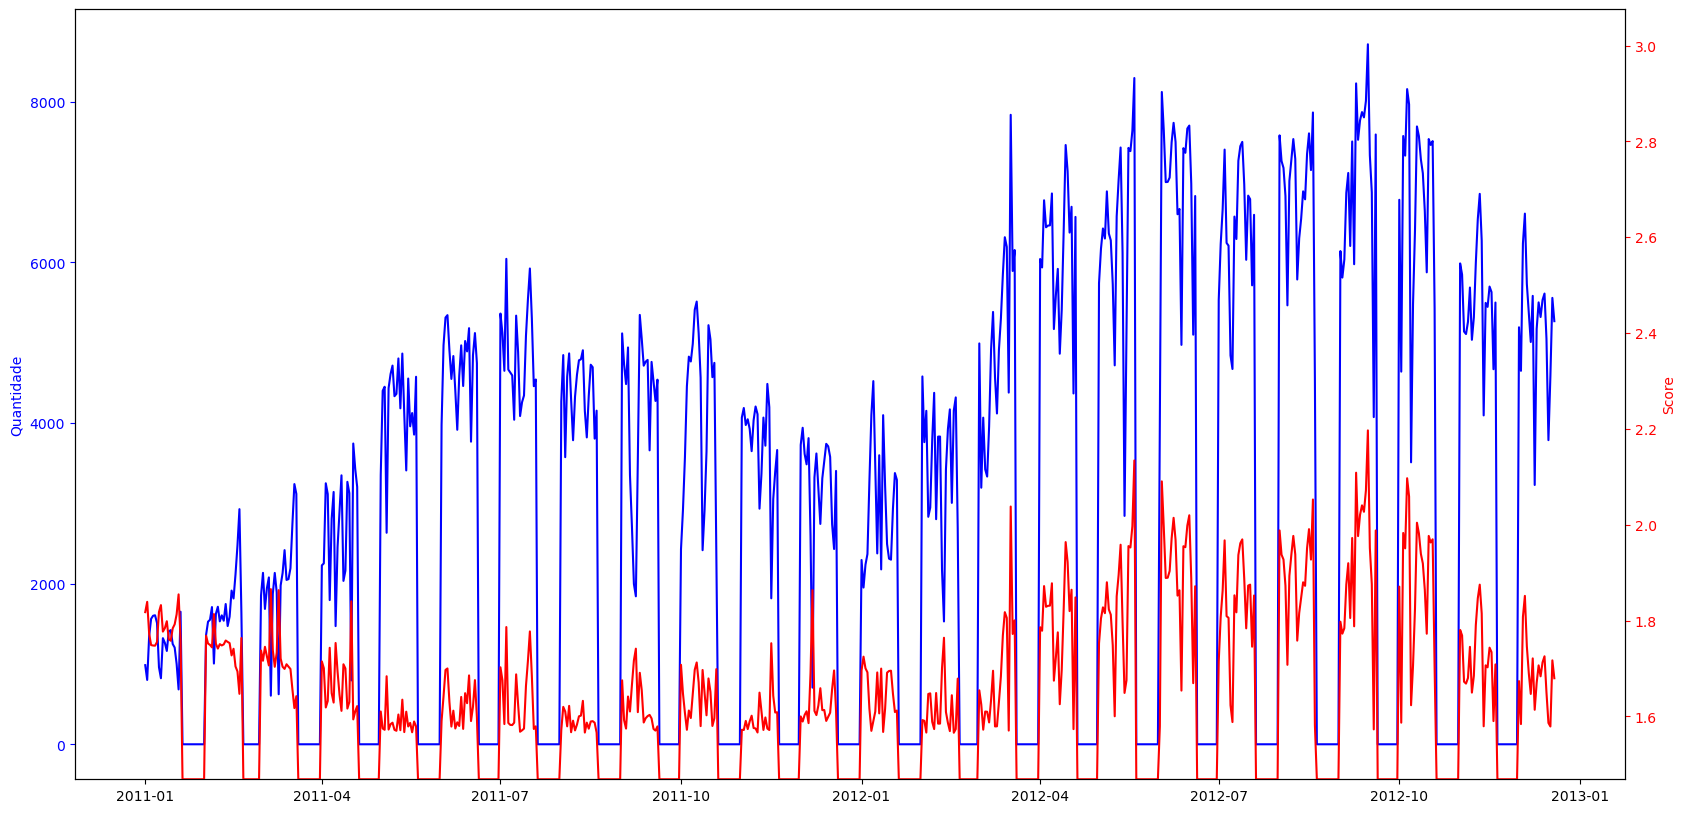

In [27]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax1.plot(df['count'], color='b')
ax2.plot(df['score'], color='r')

ax1.set_ylabel('Quantidade', color='b')
ax2.set_ylabel('Score', color='r')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='r')

ax2.set_ylim(min(previsions), 1.4 * max(previsions))

In [29]:
# Os scores que tiverem acima de 3 desvios padrões acima da média são considerados anormais

#desvio padrão de score - 0.161557

In [30]:
mean_score = df['score'].mean()
mean_score

1.6281000795122391

In [31]:
std_score = df['score'].std()
std_score

0.1615573777147203

In [32]:
score_cut = mean_score + (3 * std_score)
score_cut

2.1127722126564

In [33]:
outliers = df[df['score'] > score_cut]
outliers

,count,score
datetime,,
2012-05-19,8294,2.134285
2012-09-15,8714,2.197001


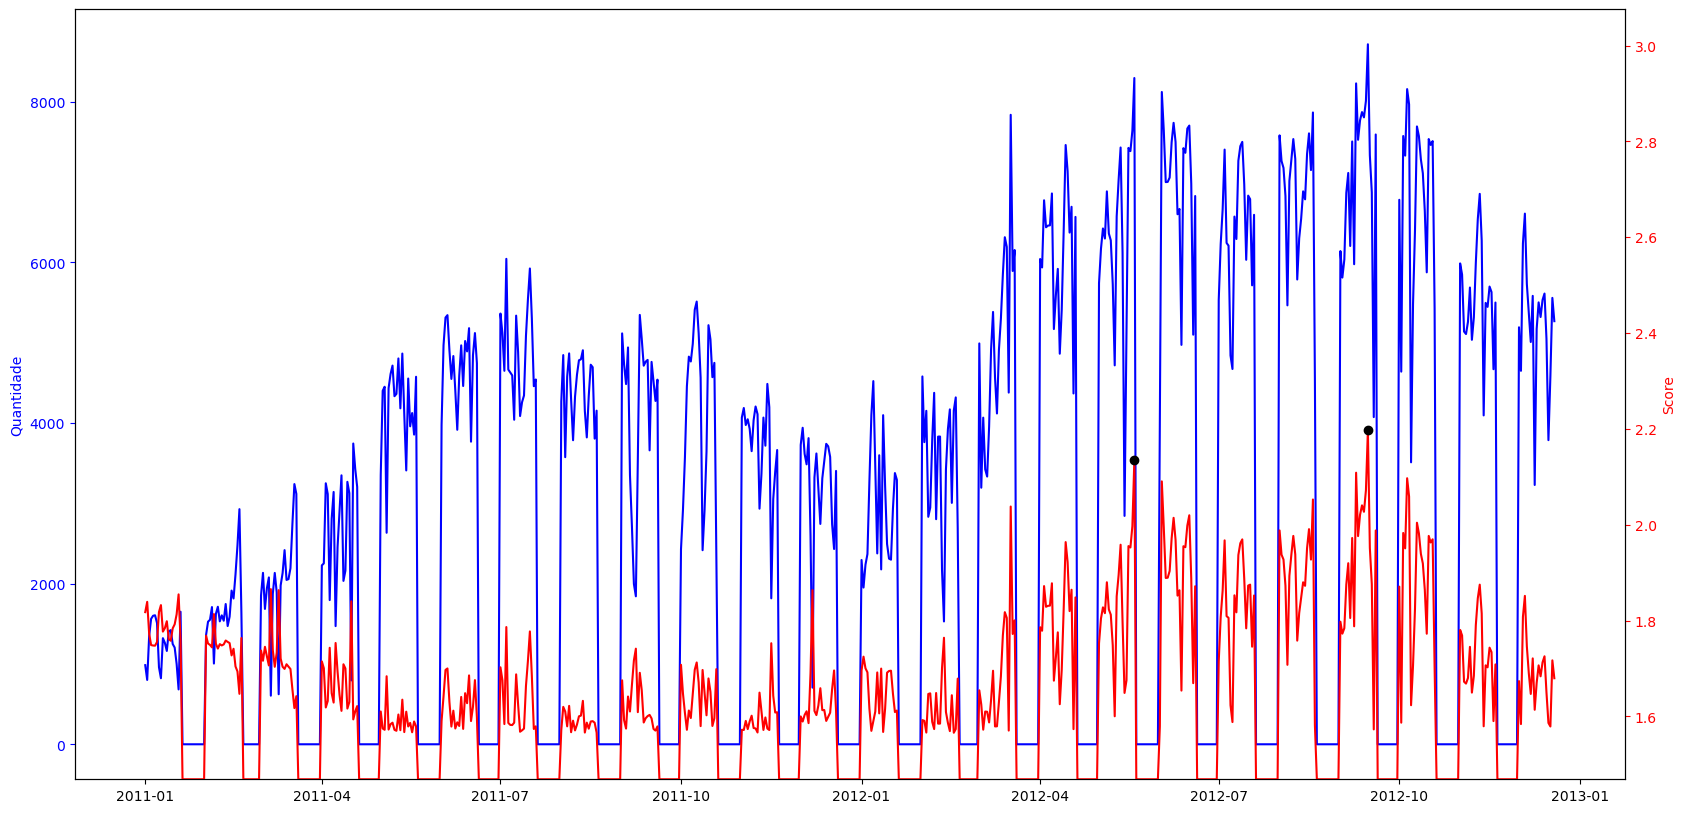

In [34]:
ax2.plot(outliers.index, outliers['score'], 'ko')
fig

In [35]:
random_cut_bikes.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: randomcutforest-2025-01-10-17-15-08-314
INFO:sagemaker:Deleting endpoint with name: randomcutforest-2025-01-10-17-15-08-314
